In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from sklearn.model_selection import StratifiedShuffleSplit

#### Read data files

This dataset is the hBones used in Chen, Jiawei, et al. "Transformer for one stop interpretable cell type annotation." Nature Communications 14.1 (2023): 223.
We used the pre-processed data with standardized annotations downloaded at the link provided by the authors: <br> https://figshare.com/articles/dataset/Pre-processed_data_for_benchmarking/24637044?file=43295985

In [4]:
ROOT_HBONES= "/dccstor/bmfm-targets/data/omics/transcriptome/scRNA/finetune/hBones/h5ad/"

train = ad.read_h5ad(ROOT_HBONES + "hBones_train_adata.h5ad")
test = ad.read_h5ad(ROOT_HBONES + "hBones_test_adata.h5ad")

2024-09-01 11:18:49.834240: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/dccstor/mm_hcls/barros/envs/bmfm/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/dccstor/mm_hcls/barros/envs/bmfm/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/dccstor/mm_hcls/barros/envs/bmfm/lib/python3.11/site-packages/sc

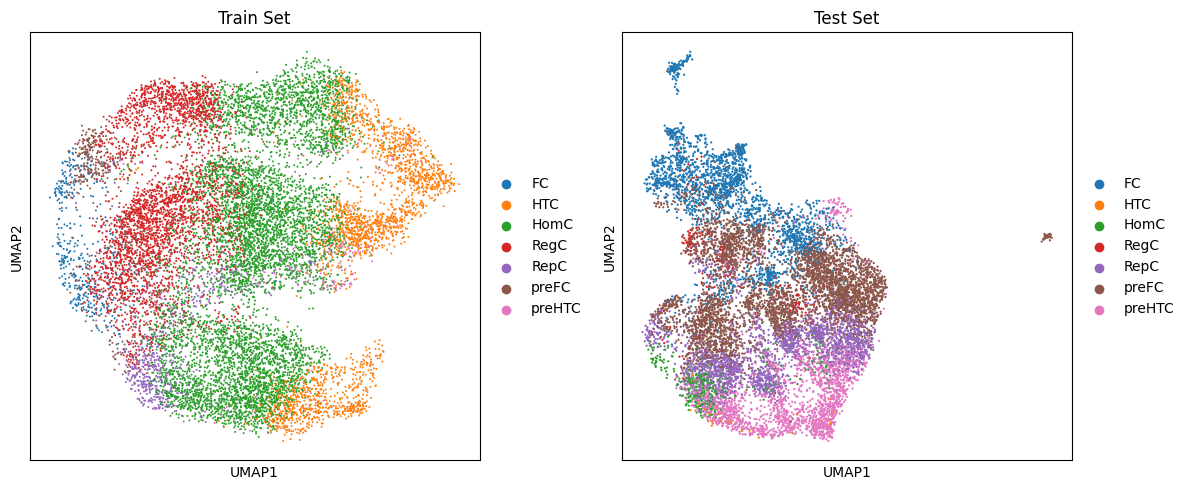

In [5]:
sc.pp.neighbors(train, use_rep='X')
sc.tl.umap(train)

sc.pp.neighbors(test, use_rep='X')
sc.tl.umap(test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.umap(train, color='celltype', ax=axes[0], show=False, title='Train Set')
sc.pl.umap(test, color='celltype', ax=axes[1], show=False, title='Test Set')

plt.tight_layout()
plt.show()

#### Create validation set and save splits in 'split_cross' column

In [6]:
hbones= ad.concat([train, test], axis=0, join='outer', merge='same')

# # create split cols
split_cross = ['train'] * train.shape[0] + ['test'] * test.shape[0]
split_cross_series = pd.Series(split_cross, index=hbones.obs.index, name='split_cross')

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_indices, dev_indices = next(splitter.split(train.obs, train.obs['celltype']))

split_cross_series.iloc[train_indices] = 'train'
split_cross_series.iloc[dev_indices] = 'dev'

hbones.obs['split_cross'] = split_cross_series
hbones.obs['split_cross'].value_counts()


split_cross
train    13153
test     11525
dev       1462
Name: count, dtype: int64

In [7]:
hbones.write(ROOT_HBONES + 'hBones.h5ad')